Topic:  **Challenge Set 1**  
Subject:  Explore MTA turnstile data  
Date:  04/16/2018  
Name:  Eric Kleinschmidt  
Worked with: Yajas Dwivedi

In [1]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
% matplotlib inline

print("Python version:", sys.version)
print("Pandas version", pd.__version__)
print("Numpy version", np.__version__)

Python version: 3.6.1 |Anaconda 4.4.0 (x86_64)| (default, May 11 2017, 13:04:09) 
[GCC 4.2.1 Compatible Apple LLVM 6.0 (clang-600.0.57)]
Pandas version 0.20.1
Numpy version 1.12.1


MTA turnstile data is available in comma delimited text files [here](http://web.mta.info/developers/turnstile.html).  Each text file contains data for one week ending on the day before the date given in the file name.

Information about the data files can be found [here](https://data.ny.gov/Transportation/Turnstile-Usage-Data-2016/ekwu-khcy). 

One weekly data file will be downloaded and entered into a pandas dataframe on which the remaining steps will be carried out.  Additional or different weeks could be added to the dataframe to extend the anlysis to larger or different time frames respectively.

In [2]:
mta_data1 = pd.read_csv('http://web.mta.info/developers/data/nyct/turnstile/turnstile_180331.txt')
mta_df1 = pd.DataFrame(mta_data1)
mta_df1.head(2)

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/24/2018,00:00:00,REGULAR,6559322,2221550
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/24/2018,04:00:00,REGULAR,6559322,2221550


In [3]:
mta_df1.shape

(196654, 11)

In [4]:
mta_df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 196654 entries, 0 to 196653
Data columns (total 11 columns):
C/A                                                                     196654 non-null object
UNIT                                                                    196654 non-null object
SCP                                                                     196654 non-null object
STATION                                                                 196654 non-null object
LINENAME                                                                196654 non-null object
DIVISION                                                                196654 non-null object
DATE                                                                    196654 non-null object
TIME                                                                    196654 non-null object
DESC                                                                    196654 non-null object
ENTRIES                           

In [5]:
mta_df1.columns

Index(['C/A', 'UNIT', 'SCP', 'STATION', 'LINENAME', 'DIVISION', 'DATE', 'TIME',
       'DESC', 'ENTRIES',
       'EXITS                                                               '],
      dtype='object')

In [6]:
# We have some whitespace in at least one column name which we will remove
mta_df1 = mta_df1.rename(columns=lambda x: x.strip())
mta_df1.columns

Index(['C/A', 'UNIT', 'SCP', 'STATION', 'LINENAME', 'DIVISION', 'DATE', 'TIME',
       'DESC', 'ENTRIES', 'EXITS'],
      dtype='object')

**Challenge 1** - Combine C/A, UNIT, SCP into a single string that represents a turnstile.  Since we are using pandas, we will combine (concatenate) these columns into a single column in the dataframe and drop the original columns.  We will also drop the LINENAME, DIVISION, DESC and EXITS columns because they will not be used in the next steps.

In [7]:
mta_df1['TURNSTILE'] = mta_df1['C/A'] + ' ' + mta_df1['UNIT'] + ' ' + mta_df1['SCP']
mta_df1 = mta_df1.drop(['C/A', 'UNIT', 'SCP', 'LINENAME', 'DIVISION', 'DESC', 'EXITS'], axis=1)
mta_df1.head(1)

,STATION,DATE,TIME,ENTRIES,TURNSTILE
0,59 ST,03/24/2018,00:00:00,6559322,A002 R051 02-00-00


**Challenge 2** - Combine DATE and TIME into a single string and convert to a datetime object in a new column .

In [8]:
mta_df1["DATETIME"] = pd.to_datetime(mta_df1.DATE + " " + mta_df1.TIME, format="%m/%d/%Y %H:%M:%S")
mta_df1.head(2)

,STATION,DATE,TIME,ENTRIES,TURNSTILE,DATETIME
0,59 ST,03/24/2018,00:00:00,6559322,A002 R051 02-00-00,2018-03-24 00:00:00
1,59 ST,03/24/2018,04:00:00,6559322,A002 R051 02-00-00,2018-03-24 04:00:00


**Challenge 3** - Convert the cumulative counter value (integer) in ENTRIES for every four hours per day to show only a single value of entries per day per turnstile.  To do this, we will create new columns to collect aggregates of count, min and max grouped by day (DATE) and subtract the min from the max to result in daily entries in a new dataframe.

In [9]:
mta_daily_df1 = mta_df1.groupby(['DATE','STATION','TURNSTILE']).ENTRIES.agg(['count','min','max'])
mta_daily_df1['NUMBER_OF_ENTRIES'] = mta_daily_df1['max'] - mta_daily_df1['min']
mta_daily_df1.reset_index(inplace=True)
mta_daily_df1.head(2)

,DATE,STATION,TURNSTILE,count,min,max,NUMBER_OF_ENTRIES
0,03/24/2018,1 AV,H007 R248 00-00-00,6,13346619,13349128,2509
1,03/24/2018,1 AV,H007 R248 00-00-01,6,58559761,58562945,3184


In [10]:
mta_daily_df1.shape

(32890, 7)

In [11]:
# We would expect a count of 6 for each turnstile in this dataset, one for each four hour increment of the day
# This is true for 31911 of the 32890 rows in the dataset or 97% of the data.
# We will need to review the data that does not follow this assumption to decide how to deal with it for analysis
mta_daily_df1['count'].value_counts()

6     31911
5       800
7        72
8        48
4        22
3        15
12        7
10        7
2         5
1         3
Name: count, dtype: int64

**Challenge 4** - Plot the daily time series for a turnstile.  We will use a filter for one turnstile at one station to select NUMBER_OF_ENTRIES values in a new dataframe to plot by DATE.

/Users/ericwk/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


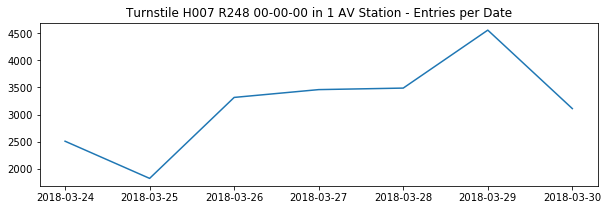

In [12]:
df_one_turnstile = mta_daily_df1[(mta_daily_df1.STATION == '1 AV') & (mta_daily_df1.TURNSTILE == 'H007 R248 00-00-00')]
df_one_turnstile['DATETIME'] = pd.to_datetime(df_one_turnstile.DATE, format="%m/%d/%Y")
plt.figure(figsize=(10,3))
plt.plot(df_one_turnstile['DATETIME'], df_one_turnstile["NUMBER_OF_ENTRIES"])
plt.title("Turnstile H007 R248 00-00-00 in 1 AV Station - Entries per Date")

**Challenge 5 & 6** - Create a time series of number of entries for each station per day

In [13]:
df_by_station = mta_daily_df1.groupby(['DATE', 'STATION']).NUMBER_OF_ENTRIES.agg([sum])
df_by_station.reset_index(inplace=True)
df_by_station = df_by_station.rename(columns={'sum':'NUMBER_OF_ENTRIES'})
df_by_station.head()

,DATE,STATION,NUMBER_OF_ENTRIES
0,03/24/2018,1 AV,15306
1,03/24/2018,103 ST,18280
2,03/24/2018,103 ST-CORONA,13322
3,03/24/2018,104 ST,872
4,03/24/2018,110 ST,7043


** Challenge 7** - Plot the time series of number of entries for each station per day

/Users/ericwk/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


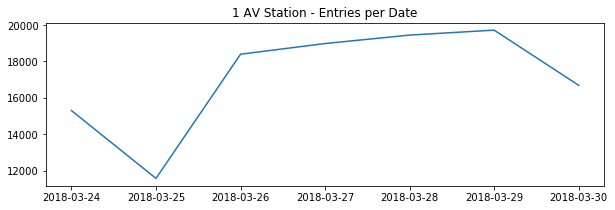

In [14]:
df_one_station = df_by_station[df_by_station.STATION == '1 AV']
df_one_station['DATETIME'] = pd.to_datetime(df_one_station.DATE, format="%m/%d/%Y")
plt.figure(figsize=(10,3))
plt.plot(df_one_station['DATETIME'], df_one_station["NUMBER_OF_ENTRIES"])
plt.title('1 AV Station - Entries per Date')

**Challenge 8** - Make a pandas series of number of entries per day for one station for each of three more weeks of data.

/Users/ericwk/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


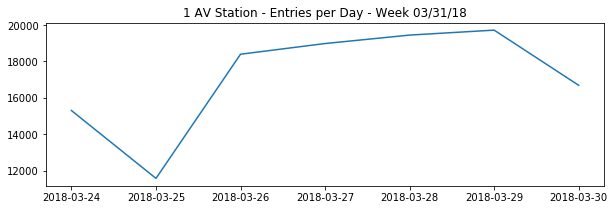

In [15]:
# Write a function to capture the code above that can be applied to any weekly data file
def make_station_df(url):
    data = pd.read_csv(url)
    df = pd.DataFrame(data)
    df = df.rename(columns=lambda x: x.strip())
    df['TURNSTILE'] = df['C/A'] + ' ' + df['UNIT'] + ' ' + df['SCP']
    df = df.drop(['C/A', 'UNIT', 'SCP', 'LINENAME', 'DIVISION', 'DESC', 'EXITS'], axis=1)
    daily_df = df.groupby(['DATE','STATION','TURNSTILE']).ENTRIES.agg(['count','min','max'])
    daily_df['NUMBER_OF_ENTRIES'] = daily_df['max'] - daily_df['min']
    daily_df.reset_index(inplace=True)
    df_by_station = daily_df.groupby(['DATE', 'STATION']).NUMBER_OF_ENTRIES.agg([sum])
    df_by_station.reset_index(inplace=True)
    df_by_station = df_by_station.rename(columns={'sum':'NUMBER_OF_ENTRIES'})
    df_one_station = df_by_station[df_by_station.STATION == '1 AV']
    df_one_station['DATETIME'] = pd.to_datetime(df_one_station.DATE, format="%m/%d/%Y")
    return df_one_station

# Run the function on the same weekly data set as above to test
df_one_station_1 = make_station_df('http://web.mta.info/developers/data/nyct/turnstile/turnstile_180331.txt')

# Write a fuction to plot the dataframe
def plot_df(df, plot_title):
    plt.figure(figsize=(10,3))
    plt.plot(df['DATETIME'], df["NUMBER_OF_ENTRIES"])
    plt.title(plot_title)
    
# Run the function on the same data as above to test
# Plots are identical - functions check
plot_df(df_one_station_1, '1 AV Station - Entries per Day - Week 03/31/18')

/Users/ericwk/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


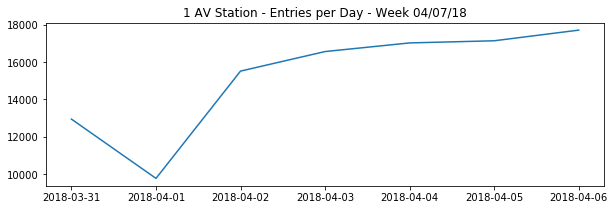

In [16]:
# Run function make_station_df to make dataframe from data for second week
df_one_station_2 = make_station_df('http://web.mta.info/developers/data/nyct/turnstile/turnstile_180407.txt')

# Run the plot_df function to plot the data for second week
plot_df(df_one_station_2, '1 AV Station - Entries per Day - Week 04/07/18')

/Users/ericwk/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


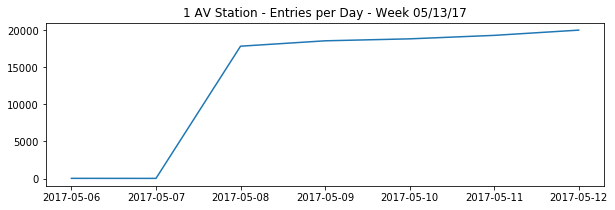

In [17]:
# Run function make_station_df to make dataframe from data for third week
df_one_station_3 = make_station_df('http://web.mta.info/developers/data/nyct/turnstile/turnstile_170513.txt')

# Run the plot_df function to plot the data for third week
plot_df(df_one_station_3, '1 AV Station - Entries per Day - Week 05/13/17')

/Users/ericwk/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


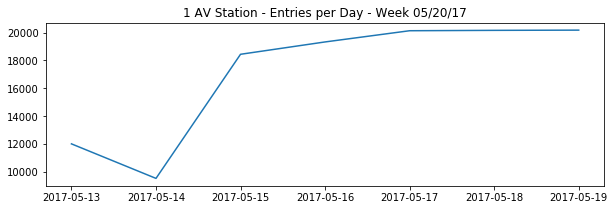

In [18]:
# Run function make_station_df to make dataframe from data for fourth week
df_one_station_4 = make_station_df('http://web.mta.info/developers/data/nyct/turnstile/turnstile_170520.txt')

# Run the plot_df function to plot the data for fourth week
plot_df(df_one_station_4, '1 AV Station - Entries per Day - Week 05/20/17')

In [19]:
# Write function to add day column to support overlay plotting
def add_DAY_column(df):
    df['DAY'] = ['1', '2', '3', '4', '5', '6', '7']
    return df

df_one_station_1 = add_DAY_column(df_one_station_1)
df_one_station_2 = add_DAY_column(df_one_station_2)
df_one_station_3 = add_DAY_column(df_one_station_3)
df_one_station_4 = add_DAY_column(df_one_station_4)

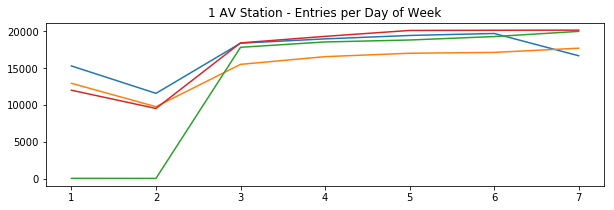

In [20]:
# Make overlay plot all for weeks of entries for one station
plt.figure(figsize=(10,3))
plt.plot(df_one_station_1['DAY'], df_one_station_1["NUMBER_OF_ENTRIES"])
plt.plot(df_one_station_2['DAY'], df_one_station_2["NUMBER_OF_ENTRIES"])
plt.plot(df_one_station_3['DAY'], df_one_station_3["NUMBER_OF_ENTRIES"])
plt.plot(df_one_station_4['DAY'], df_one_station_4["NUMBER_OF_ENTRIES"])
plt.title('1 AV Station - Entries per Day of Week')

**Challenge 9** Sum total ridership (TOTAL_ENTRIES) for each station over the four weeks above and sort them

In [21]:
'''Write a function to read the data file and make a dataframe for each of the four weeks of data 
grouped by DATE, STATION and TURNSTILE with aggregate sum of NUMBER_OF_ENTRIES'''

def make_mta_df(url):
    data = pd.read_csv(url)
    df = pd.DataFrame(data)
    df = df.rename(columns=lambda x: x.strip())
    df['TURNSTILE'] = df['C/A'] + ' ' + df['UNIT'] + ' ' + df['SCP']
    df = df.drop(['C/A', 'UNIT', 'SCP', 'LINENAME', 'DIVISION', 'DESC', 'EXITS'], axis=1)
    daily_df = df.groupby(['DATE','STATION','TURNSTILE']).ENTRIES.agg(['count','min','max'])
    daily_df['NUMBER_OF_ENTRIES'] = daily_df['max'] - daily_df['min']
    # This filter removes small number of values produced by counter reset dutring the day
    # In effect, this removes the data in rows that showed counter readings per day that were more or less than 6
    # as mentioned above
    daily_df = daily_df[(daily_df.NUMBER_OF_ENTRIES < 7500)] 
    daily_df.reset_index(inplace=True)
    return daily_df

df_1 = make_mta_df('http://web.mta.info/developers/data/nyct/turnstile/turnstile_180331.txt')
df_2 = make_mta_df('http://web.mta.info/developers/data/nyct/turnstile/turnstile_180407.txt')
df_3 = make_mta_df('http://web.mta.info/developers/data/nyct/turnstile/turnstile_170513.txt')
df_4 = make_mta_df('http://web.mta.info/developers/data/nyct/turnstile/turnstile_170520.txt')

In [22]:
combined_df = pd.concat([df_1, df_2, df_3, df_4], axis=0)
combined_df_by_station = combined_df.groupby(['STATION']).NUMBER_OF_ENTRIES.agg([sum])
combined_df_by_station.reset_index(inplace=True)
combined_df_by_station.sort_values('sum', ascending=False, inplace=True)
combined_df_by_station.head(10)

,STATION,sum
61,34 ST-PENN STA,3660502
233,GRD CNTRL-42 ST,3137797
59,34 ST-HERALD SQ,2648153
46,23 ST,2523638
68,42 ST-PORT AUTH,2289811
14,14 ST-UNION SQ,2268975
226,FULTON ST,2128021
353,TIMES SQ-42 ST,2025969
110,86 ST,1922081
9,125 ST,1827359


**Challenge 10** Plot as a histogram

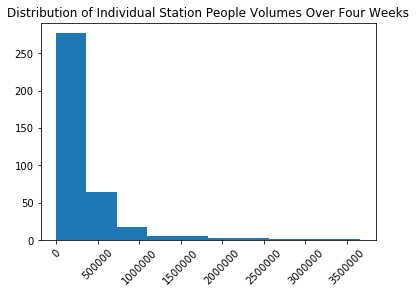

In [23]:
plt.hist(combined_df_by_station['sum'])
plt.xticks(rotation=45)
plt.title("Distribution of Individual Station People Volumes Over Four Weeks")